#Qiskit 103
3 server 3 vm

Riparto da Qiskit 97 che ha bei valori

##Beginning settings

In [6]:
try: INSTALLED
except NameError: INSTALLED = None

if INSTALLED!=1:
  !pip install Qiskit ipywidgets
  !pip install qiskit
  !pip install qiskit_optimization
  !pip install qiskit-optimization
  !pip install cplex
  !pip install ibm-quantum-widgets
  !pip install docplex
  INSTALLED=1

In [7]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [8]:
import time
from typing import List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.translators import from_docplex_mp

from qiskit.utils.algorithm_globals import algorithm_globals
algorithm_globals.massive=True

# If CPLEX is installed, you can uncomment this line to import the CplexOptimizer.
# CPLEX can be used in this tutorial to solve the convex continuous problem,
# but also as a reference to solve the QUBO, or even the full problem.
#
# from qiskit.optimization.algorithms import CplexOptimizer

In [9]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO,
# or as a benchmark for the full problem.
#
# cplex = CplexOptimizer()

<ipython-input-9-c20419085584>:5: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))
<ipython-input-9-c20419085584>:8: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs


##Problem definition

In [10]:
# construct model using docplex
mdl = Model("ex51")

#server = M = 4 = i = i0, i1, i2, i3
#virtual machine = N = 4 = j = j0, j1, j2, j3
#all servers have the same idle and dynamic power consumption
#all servers have the same maximum cpu capacity

si0 = mdl.binary_var(name="si0")
si1 = mdl.binary_var(name="si1")
si2 = mdl.binary_var(name="si2")
si3 = mdl.binary_var(name="si3")

vj0i0 = mdl.continuous_var(name="vj0i0")
vj1i0 = mdl.continuous_var(name="vj1i0")
vj2i0 = mdl.continuous_var(name="vj2i0")
vj3i0 = mdl.continuous_var(name="vj3i0")

vj0i1 = mdl.continuous_var(name="vj0i1")
vj1i1 = mdl.continuous_var(name="vj1i1")
vj2i1 = mdl.continuous_var(name="vj2i1")
vj3i1 = mdl.continuous_var(name="vj3i1")

vj0i2 = mdl.continuous_var(name="vj0i2")
vj1i2 = mdl.continuous_var(name="vj1i2")
vj2i2 = mdl.continuous_var(name="vj2i2")
vj3i2 = mdl.continuous_var(name="vj3i2")

#vj0i3 = mdl.continuous_var(name="vj0i3")
#vj1i3 = mdl.continuous_var(name="vj1i3")
#vj2i3 = mdl.continuous_var(name="vj2i3")
#vj3i3 = mdl.continuous_var(name="vj3i3")

pi = 1
pd = 1
pi0 = 1
pd0 = 1
pi1 = 1
pd1 = 1
pi2 = 1
pd2 = 1
ci0 = 200
ci1 = 160
ci2 = 120
ci3 = 120


uj0 = mdl.continuous_var(name="uj0")
uj1 = mdl.continuous_var(name="uj1")
uj2 = mdl.continuous_var(name="uj2")
uj3 = mdl.continuous_var(name="uj3")

sum0 = (vj0i0+vj1i0+vj2i0)
sum1 = (vj0i1+vj1i1+vj2i1)
sum2 = (vj0i2+vj1i2+vj2i2)
#sum3 = (vj0i3+vj1i3+vj2i3)

mdl.minimize(pi0*si0+pd0*(uj0*vj0i0+uj1*vj1i0+uj2*vj2i0+uj3*vj3i0)+pi1*si1+pd1*(uj0*vj0i1+uj1*vj1i1+uj2*vj2i1+uj3*vj3i1)+pi2*si2+pd2*(uj0*vj0i2+uj1*vj1i2+uj2*vj2i2+uj3*vj3i2))

mdl.add_constraint((vj0i0+vj1i0+vj2i0) >= ci0-5, "cons2")
mdl.add_constraint((vj0i1+vj1i1+vj2i1) >= ci1-5, "cons3")
mdl.add_constraint((vj0i2+vj1i2+vj2i2) >= ci2-5, "cons4")
#mdl.add_constraint((vj0i3+vj1i3+vj2i3) >= ci3-5, "cons5")

mdl.add_constraint((vj0i0+vj1i0+vj2i0) >= 0, "cons6")
mdl.add_constraint((vj0i1+vj1i1+vj2i1) >= 0, "cons7")
mdl.add_constraint((vj0i2+vj1i2+vj2i2) >= 0, "cons8")
#mdl.add_constraint((vj0i3+vj1i3+vj2i3) >= 0, "cons9")

#mdl.add_constraint((vj0i0+vj1i0+vj2i0) <= ci0,"cons10")
#mdl.add_constraint((vj0i1+vj1i1+vj2i1) <= ci1, "cons11")
#mdl.add_constraint((vj0i2+vj1i2+vj2i2) <= ci2, "cons12")

mdl.add_constraint((si0) >= 1, "cons14")
mdl.add_constraint((si1) >= 1, "cons15")
mdl.add_constraint((si2) >= 1, "cons16")
mdl.add_constraint((si3) >= 1, "cons17")

mdl.add_constraint((vj0i0+vj0i1+vj0i2) <= ci0,"cons18")
mdl.add_constraint((vj1i0+vj1i1+vj1i2) <= ci1,"cons19")
mdl.add_constraint((vj2i0+vj2i1+vj2i2) <= ci2,"cons20")
mdl.add_constraint((vj3i0+vj3i1+vj3i2) <= ci3,"cons21")

mdl.add_constraint(uj0 >= 1,"cons22")
mdl.add_constraint(uj1 >= 1,"cons23")
mdl.add_constraint(uj2 >= 1,"cons24")
mdl.add_constraint(uj3 >= 1,"cons25")


docplex.mp.LinearConstraint[cons25](uj3,GE,1)

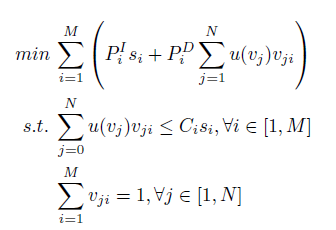

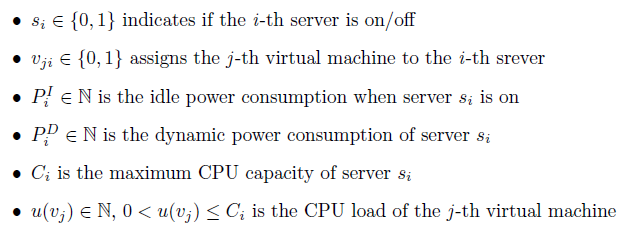

In [11]:
# load quadratic program from docplex model
qp = from_docplex_mp(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: ex51

Minimize
 obj: si0 + si1 + si2 + [ 2 vj0i0*uj0 + 2 vj1i0*uj1 + 2 vj2i0*uj2 + 2 vj3i0*uj3
      + 2 vj0i1*uj0 + 2 vj1i1*uj1 + 2 vj2i1*uj2 + 2 vj3i1*uj3 + 2 vj0i2*uj0
      + 2 vj1i2*uj1 + 2 vj2i2*uj2 + 2 vj3i2*uj3 ]/2
Subject To
 cons2: vj0i0 + vj1i0 + vj2i0 >= 195
 cons3: vj0i1 + vj1i1 + vj2i1 >= 155
 cons4: vj0i2 + vj1i2 + vj2i2 >= 115
 cons6: vj0i0 + vj1i0 + vj2i0 >= 0
 cons7: vj0i1 + vj1i1 + vj2i1 >= 0
 cons8: vj0i2 + vj1i2 + vj2i2 >= 0
 cons14: si0 >= 1
 cons15: si1 >= 1
 cons16: si2 >= 1
 cons17: si3 >= 1
 cons18: vj0i0 + vj0i1 + vj0i2 <= 200
 cons19: vj1i0 + vj1i1 + vj1i2 <= 160
 cons20: vj2i0 + vj2i1 + vj2i2 <= 120
 cons21: vj3i0 + vj3i1 + vj3i2 <= 120
 cons22: uj0 >= 1
 cons23: uj1 >= 1
 cons24: uj2 >= 1
 cons25: uj3 >= 1

Bounds
 0 <= si0 <= 1
 0 <= si1 <= 1
 0 <= si2 <= 1
 0 <= si3 <= 1

Binaries
 si0 si1 si2 si3
End



##Classical solution

In [12]:
admm_params = ADMMParameters(
                            rho_initial=1001,
                            beta=1000,
                            factor_c=900,
                            maxiter=100,
                            three_block=True, tol=1.e-6
                        )

In [13]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params,
                     qubo_optimizer=qubo_optimizer,
                     continuous_optimizer=convex_optimizer,
                    )

In [14]:
# run ADMM to solve problem
import time
t1 = time.perf_counter()

result = admm.solve(qp)

t2 = time.perf_counter()
print('time taken to run:',round(t2-t1),' seconds')
#%tb
#%timeit

time taken to run: 1063  seconds


In [15]:
print(result.prettyprint())

objective function value: 468.0
variable values: si0=1.0, si1=1.0, si2=1.0, si3=0.0, vj0i0=75.65064172048031, vj1i0=66.08131914185911, vj2i0=53.2680391376606, vj3i0=8.85948198757575e-19, vj0i1=61.76766742968664, vj1i1=53.61552682659667, vj2i1=39.61680574371669, vj3i1=-3.6330242586393665e-18, vj0i2=47.97662332188564, vj1i2=40.02426146183924, vj2i2=26.999115216275126, vj3i2=-1.4325386805999093e-18, uj0=1.0, uj1=1.0, uj2=1.0, uj3=0.9999999999999999
status: INFEASIBLE


* objective function value: 468.0
* si0=1.0, si1=1.0, si2=1.0, si3=0.0
* vj0i0=75.65, vj1i0=66.08, vj2i0=53.27, vj3i0=0
* vj0i1=61.77, vj1i1=53.62, vj2i1=39.62, vj3i1=0,
* vj0i2=47.98, vj1i2=40.02, vj2i2=27,00, vj3i2=0,
* uj0=1.0, uj1=1.0, uj2=1.0, uj3=1.0
* status: INFEASIBLE


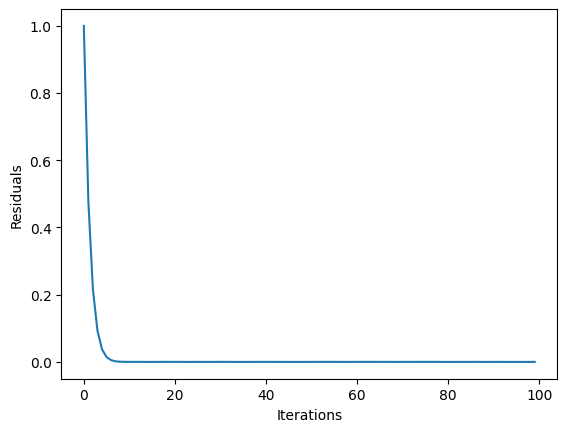

In [16]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [17]:
print(result)
print(result.state)
print(admm.get_compatibility_msg(qp))
admm.get_compatibility_msg(qp)

fval=468.0, si0=1.0, si1=1.0, si2=1.0, si3=0.0, vj0i0=75.65064172048031, vj1i0=66.08131914185911, vj2i0=53.2680391376606, vj3i0=8.85948198757575e-19, vj0i1=61.76766742968664, vj1i1=53.61552682659667, vj2i1=39.61680574371669, vj3i1=-3.6330242586393665e-18, vj0i2=47.97662332188564, vj1i2=40.02426146183924, vj2i2=26.999115216275126, vj3i2=-1.4325386805999093e-18, uj0=1.0, uj1=1.0, uj2=1.0, uj3=0.9999999999999999, status=INFEASIBLE



''

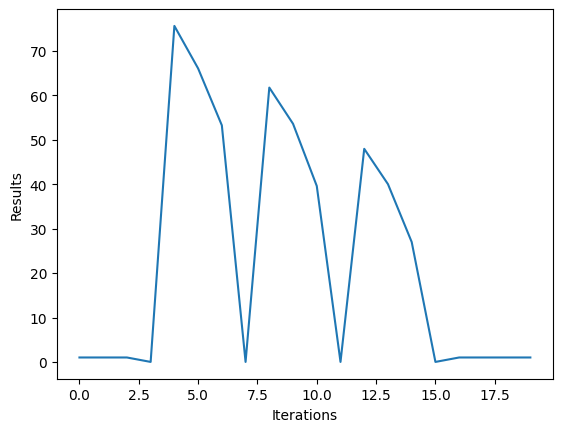

In [18]:
plt.plot(result.x)
plt.xlabel("Iterations")
plt.ylabel("Results")
plt.show()

<qiskit_optimization.algorithms.admm_optimizer.ADMMState at 0x7f139d9c9a10>

##Quantum solution

In [19]:
# define QUBO optimizer
qubo_optimizer = qaoa

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with quantum QUBO optimizer and classical convex optimizer
admm_q = ADMMOptimizer(
    params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer
)

In [ ]:
# run ADMM to solve problem
import time
t1 = time.perf_counter()

result_q = admm_q.solve(qp)

t2 = time.perf_counter()
print('time taken to run:',round(t2-t1),' seconds')
#%tb
#%timeit

KeyboardInterrupt: ignored

In [ ]:
print(result_q.prettyprint())

* objective function value: 468.0
* si0=1.0, si1=1.0, si2=1.0, si3=0.0
* vj0i0=75.45, vj1i0=66.245, vj2i0=53.31, vj3i0=0
* vj0i1=61.49, vj1i1=53.55, vj2i1=39.95, vj3i1=0.03
* vj0i2=48.42, vj1i2=40.13, vj2i2=26.45, vj3i2=0.07
* vj0i3=38.58, vj1i3=38.06, vj2i3=38.43, vj3i3=0.05
* uj0=1, uj1=1, uj2=1.0, uj3=1.1
* status: INFEASIBLE

In [ ]:
plt.clf()
plt.plot(result_q.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.plot(result_q.x)
plt.xlabel("Iterations")
plt.ylabel("Results")
plt.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright